<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/2-language-models-lab/2-text-classifier-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification ##

This notebook is based on this Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
        
In this notebook, we will train a network to learn how to classify news articles by category. We will tokenize per character rather than per word

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datasets import load_dataset
from pyprojroot import here

# Load AG News dataset
dataset = load_dataset("ag_news", cache_dir=here("data", "datasets_cache"))

# Access the data
train_data = dataset['train']
test_data = dataset['test']

category_lines = {}
all_categories = ['World', 'Sports', 'Business', 'Technology']

# Process training data
for item in train_data:
    category = all_categories[item['label']]
    text = item['text']
    
    if category not in category_lines:
        category_lines[category] = []
    category_lines[category].append(text)

n_categories = len(all_categories)
print(f"Number of categories: {n_categories}")
print(f"Categories: {all_categories}")

Number of categories: 4
Categories: ['World', 'Sports', 'Business', 'Technology']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Vocabulary - expanded for news text
all_letters = string.ascii_letters + " .,;'!?0123456789"
n_letters = len(all_letters)

print(f"Vocabulary size: {n_letters}")

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Vocabulary size: 69
Slusarski


In [ ]:
# Show sample data from each category
print("Sample data from each category:")
for category in all_categories:
    print(f"\n{category} ({len(category_lines[category])} samples):")
    print(f"  {category_lines[category][0][:100]}...")

Sample data from each category:

World (30000 samples):
  Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early...

Sports (30000 samples):
  Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Oly...

Business (30000 samples):
  Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...

Technology (30000 samples):
  'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\...


In [ ]:
# Show some examples from different categories
print("Sample World news:")
for i, text in enumerate(category_lines['World'][:3]):
    print(f"{i+1}: {text[:80]}...")

print("\nSample Sports news:")
for i, text in enumerate(category_lines['Sports'][:3]):
    print(f"{i+1}: {text[:80]}...")

Sample World news:
1: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuel...
2: S.Koreans Clash with Police on Iraq Troop Dispatch (Reuters) Reuters - South Kor...
3: Palestinians in Israeli Jails Start Hunger Strike (Reuters) Reuters - Thousands ...

Sample Sports news:
1: Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qu...
2: Reds Knock Padres Out of Wild-Card Lead (AP) AP - Wily Mo Pena homered twice and...
3: Dreaming done, NBA stars awaken to harsh Olympic reality (AFP) AFP - National Ba...


### Make everything into one-hot vector ###

For it to be used (transform into a tensor). Here we are doing a character-based one-hot vector

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    # Clean the line first and truncate if too long
    line = unicodeToAscii(line)
    if len(line) > 200:  # Limit length to avoid memory issues
        line = line[:200]
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        if letterToIndex(letter) >= 0:  # Only process valid letters
            tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(letterToTensor('o'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 1, 69])


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#         print(x.shape)
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#         print(hidden.shape)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [ ]:
x = letterToTensor('A')
print(x.shape)
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()
print(hidden.shape)

output, next_hidden = rnn(x, hidden)
print(output.argmax(-1))
print(output.topk(3).indices)

torch.Size([1, 69])
torch.Size([1, 128])
tensor([1])
tensor([[1, 2, 3]])


In [ ]:
x = lineToTensor('Alberto')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
output, next_hidden = rnn(x[1], next_hidden)
output, next_hidden = rnn(x[2], next_hidden)
output, next_hidden = rnn(x[3], next_hidden)
output, next_hidden = rnn(x[4], next_hidden)
output, next_hidden = rnn(x[5], next_hidden)
output, next_hidden = rnn(x[6], next_hidden)
print(output.argmax(-1))

tensor([1])


## Preparing for training! ##

In [ ]:
# Helper function to get the actual category from the best

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Sports', 1)


### Quick way to get training example (Src = Text, Trg = Category) ###

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    # Truncate very long texts to avoid memory issues
    if len(line) > 200:
        line = line[:200]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# Test the function
for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line[:50] + "...")

category = Sports / line = Heartbreak for Deakes Sloping off: Nathan Deakes w...
category = Sports / line = UPDATE 1-Everton #39;s Rooney hands in transfer re...
category = Business / line = Crane Shares Rise on Settlement News  BOSTON (Reut...
category = Sports / line = St. Louis Cardinals News With the National League ...
category = Sports / line = Knicks get defensive Someone asked Knicks point gu...


In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



## Train now!!! ##

In [ ]:
def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train with the RNN from scratch ####

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 2000  # More frequent updates
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

print("Starting training...")
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line[:30]+"...", guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Starting training...
2000 20% (2m 0s) 1.3839 Millar #39;s homer in 11th lif... / Technology ✗ (Sports)
4000 40% (4m 1s) 1.3800 Decision near Jim Leyland #39;... / Business ✗ (Sports)
6000 60% (6m 3s) 1.4001 Economic Growth Better Than Th... / World ✗ (Business)
8000 80% (8m 3s) 1.2856 Holdsclaw Speaks Out The Mysti... / Technology ✗ (Sports)
10000 100% (10m 3s) 1.6191 Property market faces up to 12... / Sports ✗ (Business)


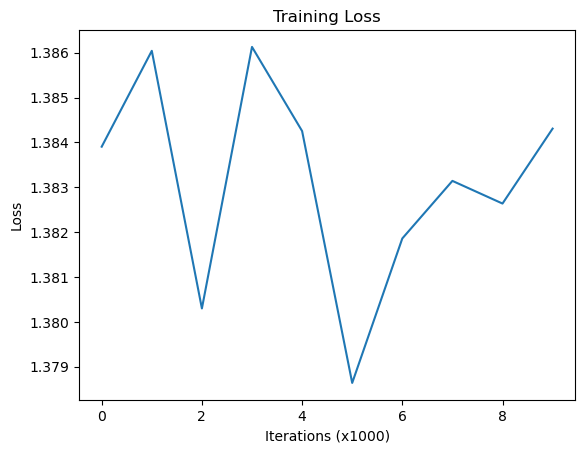

In [ ]:
# PLOT THE RESULT
plt.figure()
plt.plot(all_losses)
plt.title('Training Loss')
plt.xlabel('Iterations (x1000)')
plt.ylabel('Loss')
plt.show()

## Evaluate the results with a confusion matrix! ##

Evaluating model...
Accuracy: 0.260


C:\Users\Plancha\AppData\Local\Temp\ipykernel_44960\3988197108.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=45)
C:\Users\Plancha\AppData\Local\Temp\ipykernel_44960\3988197108.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


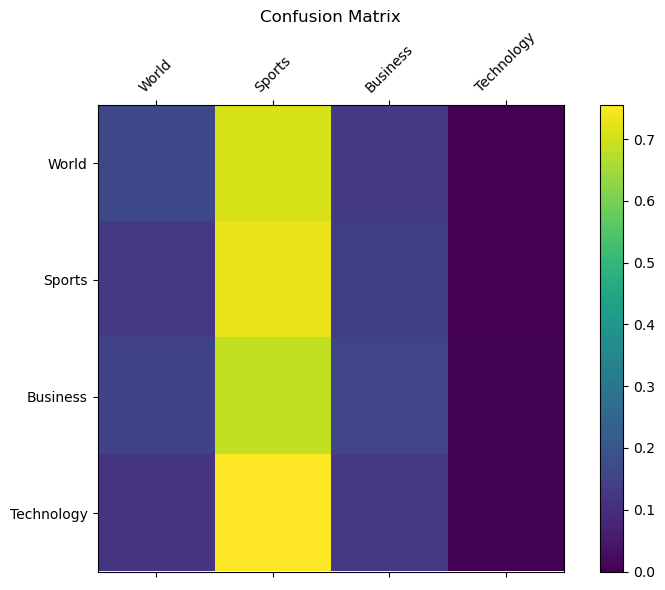

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000  # Reduced for faster evaluation

# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
print("Evaluating model...")
correct_predictions = 0
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_basic)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    if guess == category:
        correct_predictions += 1

accuracy = correct_predictions / n_confusion
print(f"Accuracy: {accuracy:.3f}")

# Normalize by dividing every row by its sum
for i in range(n_categories):
    if confusion[i].sum() > 0:
        confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=45)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Now we can try predicting our own things! ##

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        # Truncate if too long
        if len(input_line) > 200:
            input_line = input_line[:200]
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# Test predictions with news-like text
predict('Apple announces new iPhone with advanced AI features')
predict('The football team won the championship game yesterday')
predict('Stock market rises as tech companies report strong earnings')
predict('Scientists discover new planet in distant galaxy')


> Apple announces new iPhone with advanced AI features
(-1.35) World
(-1.36) Business
(-1.37) Sports

> The football team won the championship game yesterday
(-1.36) World
(-1.36) Business
(-1.39) Sports

> Stock market rises as tech companies report strong earnings
(-1.34) Business
(-1.39) Sports
(-1.40) World

> Scientists discover new planet in distant galaxy
(-1.35) Sports
(-1.36) World
(-1.38) Business


### So now lets shift to using the RNN Module from Pytorch ###

In [ ]:
def categoryToTensor(category):
    tensor = torch.zeros([1, len(all_categories)], dtype=torch.long)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    # Truncate very long texts
    if len(line) > 200:
        line = line[:200]
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# Test the function
for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line[:50] + "...")

category = Technology / line = Vodafone begins 3G mobile service Vodafone launche...
category = Sports / line = NL Wrap: 5-Hit Beltre Leads Dodgers to Win Over Me...
category = World / line = Third US Soldier Killed in Afghan Clashes A US sol...
category = Technology / line = European robot looks for clues on Saturn moon Afte...
category = Sports / line = Pound says Jones case pivotal in doping fight If t...


In [ ]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [ ]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)
    
#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train from the RNN using pytorch approach ####

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 50000  # Reduced iterations
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

print("Starting PyTorch RNN training...")
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line[:30]+"...", guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Starting PyTorch RNN training...
5000 10% (0m 17s) 1.4197 Karmazin Brings Sirius Starpow... / World ✗ (Technology)
10000 20% (0m 35s) 1.3551 First flight test of new missi... / Technology ✗ (Business)
15000 30% (0m 52s) 1.3920 College Recruiters Lure Studen... / Business ✗ (Technology)
20000 40% (1m 10s) 1.3370 Time Warner Stock Has Room to ... / Business ✗ (Technology)
25000 50% (1m 27s) 1.5666 Officials say Linux not a pric... / Sports ✗ (Technology)
30000 60% (1m 45s) 1.3488 IBM protects passwords with PC... / Sports ✗ (Technology)
35000 70% (2m 2s) 1.5445 Don't Marry Until March Plan a... / Sports ✗ (Business)
40000 80% (2m 19s) 1.5988 JDS Uniphase Posts Deeper 1Q L... / Sports ✗ (Business)
45000 90% (2m 37s) 1.1679 Consumer confidence takes tumb... / Business ✓
50000 100% (2m 54s) 1.5018 Windies into semis Ricardo Pow... / Technology ✗ (Sports)


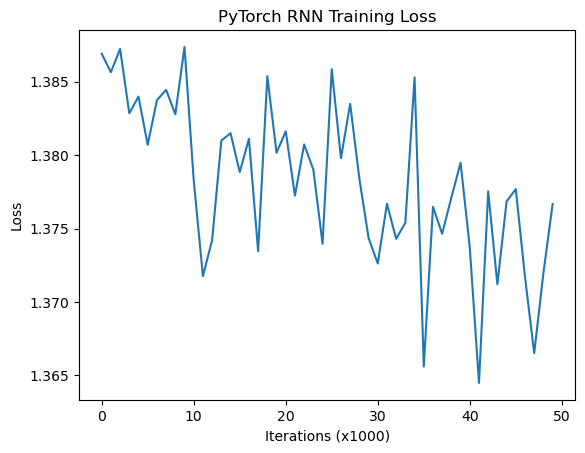

In [ ]:
# PLOT THE RESULT
plt.figure()
plt.plot(all_losses)
plt.title('PyTorch RNN Training Loss')
plt.xlabel('Iterations (x1000)')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        # Truncate if too long
        if len(input_line) > 200:
            input_line = input_line[:200]
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# Test predictions with news-like text
predict('Apple announces new iPhone with advanced AI features')
predict('The football team won the championship game yesterday')
predict('Stock market rises as tech companies report strong earnings')
predict('Scientists discover new planet in distant galaxy')


> Apple announces new iPhone with advanced AI features
(-1.29) World
(-1.39) Sports
(-1.42) Technology

> The football team won the championship game yesterday
(-1.16) World
(-1.31) Business
(-1.54) Sports

> Stock market rises as tech companies report strong earnings
(-1.24) Business
(-1.36) Technology
(-1.47) World

> Scientists discover new planet in distant galaxy
(-1.15) Sports
(-1.28) World
(-1.45) Business
